In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install evaluate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import xml.etree.ElementTree as ET
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM, BatchNormalization
from gensim.parsing.preprocessing import preprocess_string
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report
import time
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform, RandomNormal, GlorotNormal
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import Dataset
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import pandas as pd
import torch
# Load model directly
# from transformers import BertTokenizer, BertForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import default_data_collator
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from imblearn.keras import BalancedBatchGenerator
from datasets import load_metric
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from datasets import DatasetDict
import os
import joblib
from google.colab import drive

random_state = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Descargar recursos de nltk si es necesario
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
# Función para limpiar y tokenizar el texto
def preprocess_question_stopwords(text):
  if text is None:
    return ''
  # Tokenizar el texto
  stop_words = set(stopwords.words('english'))
  tokens = word_tokenize(text)
  # Eliminar stop words
  text_tokens = [word for word in tokens if word not in stopwords.words('english')]
  text = ' '.join([word for word in text_tokens if word not in stop_words])
  # return tokens
  return text

def preprocess_question_no_stopwords(text):
  if text is None:
    return ''
  # Convertir a minúsculas
  text = text.strip()
  text = ' '.join(text.split())
  text = text.lower()
  # Eliminar etiquetas HTML (si las hubiera)
  text = re.sub(r'<.*?>', '', text)
  # Sustituir o eliminar caracteres especiales
  text = re.sub(r'&amp;quot;', "", text)
  text = re.sub(r'&apos;', "'", text)
  text = re.sub(r'&quot;', "", text)
  text = re.sub(r'&amp;/', "", text)
  text = re.sub(r'&amp;', "", text)
  text = re.sub(r'&gt;', "'", text)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  return text

def preprocess_focus_type(text):
  if text is None:
    return ''
  # Convertir a minúsculas
  text = text.strip()
  text = text.lower()
  # Eliminar etiquetas HTML (si las hubiera)
  text = re.sub(r'<.*?>', '', text)
  return text

In [33]:
# Cargar el archivo XML
tree_1 = ET.parse('/content/drive/MyDrive/TFB/LiveQA_MedicalTask_TREC2017/TrainingDatasets/TREC-2017-LiveQA-Medical-Train-1.xml')
tree_2 = ET.parse('/content/drive/MyDrive/TFB/LiveQA_MedicalTask_TREC2017/TrainingDatasets/TREC-2017-LiveQA-Medical-Train-2.xml')
tree_test = ET.parse('/content/drive/MyDrive/TFB/LiveQA_MedicalTask_TREC2017/TestDataset/TREC-2017-LiveQA-Medical-Test.xml')
root_1 = tree_1.getroot()
root_2 = tree_2.getroot()
root_test = tree_test.getroot()
# Almacenar todos los textos preprocesados
dict_QA = []
dict_QA_test = []
id = 0
# Recorrer cada pregunta en el archivo
for question in root_1.findall('NLM-QUESTION'):
  # Procesar el mensaje principal de la pregunta
  subject = question.find('SUBJECT').text
  message = question.find('MESSAGE').text
  message = preprocess_question_no_stopwords(message)
  message_clean = preprocess_question_stopwords(message)
  subject = preprocess_focus_type(subject)

  # Recorrer cada sub-pregunta en la pregunta
  for subquestion in question.find('SUB-QUESTIONS').findall('SUB-QUESTION'):
    focus_sq = subquestion.find('ANNOTATIONS/FOCUS').text
    focus_sq = preprocess_focus_type(focus_sq)
    type_sq = subquestion.find('ANNOTATIONS/TYPE').text
    type_sq = preprocess_focus_type(type_sq)
    # Procesar cada respuesta en la sub-pregunta
    for answer in subquestion.find('ANSWERS').findall('ANSWER'):
      answer_sq = answer.text
      dict_QA.append({'id': id, 'question': message, 'question_clean': message_clean, 'subject': subject, 'focus': focus_sq,
                        'type': type_sq, 'answer': answer_sq})
      id += 1

for question in root_2.findall('NLM-QUESTION'):
  # Procesar el mensaje principal de la pregunta
  subject = question.find('SUBJECT').text
  message = question.find('MESSAGE').text
  if message:
    message = preprocess_question_no_stopwords(message)
  message_clean = preprocess_question_stopwords(message)
  subject = preprocess_focus_type(subject)
  # Recorrer cada sub-pregunta en la pregunta
  for subquestion in question.find('SUB-QUESTIONS').findall('SUB-QUESTION'):
    focus_sq = subquestion.find('ANNOTATIONS/FOCUS').text
    focus_sq = preprocess_focus_type(focus_sq)
    type_sq = subquestion.find('ANNOTATIONS/TYPE').text
    type_sq = preprocess_focus_type(type_sq)

    # Procesar cada respuesta en la sub-pregunta
    for answer in subquestion.find('ANSWERS').findall('ANSWER'):
      answer_sq = answer.text
      dict_QA.append({'id': id, 'question': message, 'question_clean': message_clean, 'subject': subject, 'focus': focus_sq,
                   'type': type_sq, 'answer': answer_sq})
      id += 1

id = 0
for question in root_test.findall('NLM-QUESTION'):
  # Procesar el mensaje principal de la pregunta
  original_question = question.find('Original-Question')
  subject = original_question.find('SUBJECT').text
  message = original_question.find('MESSAGE').text
  message = preprocess_question_no_stopwords(message)
  message_clean = preprocess_question_stopwords(message)
  subject = preprocess_focus_type(subject)
  focus_q = []
  type_q = []
  annotation = question.find('ANNOTATIONS')
  for focus_question in annotation.findall('FOCUS'):
    focus_clean = preprocess_focus_type(focus_question.text)
    focus_q.append(focus_clean)
  for type_question in annotation.findall('TYPE'):
    type_clean = preprocess_focus_type(type_question.text)
    if type_clean == 'side_effect' or type_clean == 'effect':
      type_clean = 'side effects'
    elif type_clean == 'storage_disposal':
      type_clean = 'storage and disposal'
    elif type_clean == 'person_organization':
      type_clean = 'organization'
    elif type_clean == 'action':
      type_clean = 'treatment'
    elif type_clean == 'comparison' or type_clean == 'other_question' or type_clean == 'lifestyle_diet' or type_clean == 'alternative':
      type_clean = 'information'
    if type_clean not in type_q:
      type_q.append(type_clean)
  focus_join = ', '.join(focus_q)
  type_join = ', '.join(type_q)
  # Procesar cada respuesta en la sub-pregunta
  for answer in question.find('ReferenceAnswers').findall('RefAnswer/ANSWER'):
    answer_sq = answer.text
    dict_QA_test.append({'id': id, 'question': message, 'question_clean': message_clean, 'focus': focus_join,
                  'type': type_join, 'answer': answer_sq})
    id += 1
  for answer in question.find('ReferenceAnswers').findall('ReferenceAnswer/ANSWER'):
    answer_sq = answer.text
    dict_QA_test.append({'id': id, 'question': message, 'question_clean': message_clean, 'focus': focus_join,
                  'type': type_join, 'answer': answer_sq})
    id += 1

df_train = pd.DataFrame(dict_QA, columns=['id', 'question', 'question_clean', 'focus', 'type', 'answer'])
df_test = pd.DataFrame(dict_QA_test, columns=['id', 'question', 'question_clean', 'focus', 'type', 'answer'])

## **Análisis inicial de los datos**

In [34]:
df_train

,id,question,question_clean,focus,type,answer
0,0,literature on cardiac amyloidosis please let m...,literature cardiac amyloidosis please let know...,cardiac amyloidosis,information,Cardiac amyloidosis is a disorder caused by de...
1,1,literature on cardiac amyloidosis please let m...,literature cardiac amyloidosis please let know...,cardiac amyloidosis,information,"The term ""amyloidosis"" refers not to a single ..."
2,2,migraine seems to be a spectrum of conditions ...,migraine seems spectrum conditions rather one ...,migraine,treatment,There is no specific cure for migraine headach...
3,3,migraine seems to be a spectrum of conditions ...,migraine seems spectrum conditions rather one ...,migraine,treatment,There is no absolute cure for migraine since i...
4,4,do i use pyridoxine tablets even if im pregnant,use pyridoxine tablets even im pregnant,pyridoxine,contraindication,"Before taking pyridoxine, tell your doc..."
...,...,...,...,...,...,...
629,629,if you should contact mrsa and take antibiotic...,contact mrsa take antibiotics long period time...,mrsa,diagnosis,"Occasionally, a person who has been treated fo..."
630,630,what if you do not have surgery to remove a pa...,surgery remove papilloma,intraductal papilloma,prognosis,Your specialist will be able to advise you of ...
631,631,thank for your information on my earlier quest...,thank information earlier question regarding c...,excessive tears,treatment,Your doctor may order tests to help determine ...
632,632,i have numbnesstingling in my lower right arm ...,numbnesstingling lower right arm elbow fingers...,numbness/tingling,treatment,Home Care Your doctor should find and treat t...


In [35]:
df_test

,id,question,question_clean,focus,type,answer
0,0,what are the references with noonan syndrome a...,references noonan syndrome polycystic renal di...,"noonan syndrome, polycystic renal disease",side effects,Noonan's syndrome is an eponymic designation ...
1,1,what are the references with noonan syndrome a...,references noonan syndrome polycystic renal di...,"noonan syndrome, polycystic renal disease",side effects,10% of patients with Noonan syndrome have rena...
2,2,what are the references with noonan syndrome a...,references noonan syndrome polycystic renal di...,"noonan syndrome, polycystic renal disease",side effects,"Genitourinary. Renal abnormalities, generally ..."
3,3,rendc 0115067250 zolmitriptan tabkets 5mg i ha...,rendc 0115067250 zolmitriptan tabkets 5mg celi...,zolmitriptan,ingredient,Zolmitriptan tablets are available as 2.5 mg (...
4,4,are they gluten free,gluten free,amphetamine salts,ingredient,\n\t\t\t\t\tActive Ingredients\n\t\t\t\t\tAmph...
...,...,...,...,...,...,...
162,162,how does effextor cause ed and what is the mim...,effextor cause ed mimimum amount causes ed tak...,effextor,side effects,Antidepressants most likely to cause sexual si...
163,163,how long has this non prescription drug been i...,long non prescription drug implicated erectile...,nsaids,side effects,Non-aspirin NSAID use was associated with an ...
164,164,i want to know more about aeortic stenosis,want know aeortic stenosis,aeortic stenosis,"information, treatment",The aorta is the main artery that carries blo...
165,165,what can cause white cells ti uprate,cause white cells ti uprate,white cells uprate,cause,A high white blood cell count usually indicat...


Para entrenar modelos que distingan el tipo de la pregunta y las palabras clave, vamos a crear un dataframe con las columnas 'question_clean', 'focus' y 'type'.

In [36]:
df_train_type = df_train.loc[:, ['question_clean', 'focus', 'type']]
df_test_type = df_test.loc[:, ['question_clean', 'focus', 'type']]
df_train_type = df_train_type.drop_duplicates(ignore_index=True)
df_test_type = df_test_type.drop_duplicates(ignore_index=True)

Nos quedamos con únicamente un tipo por pregunta (hay preguntas con varios tipos al llevar subpreguntas).

In [37]:
df_train_type.drop_duplicates(subset='question_clean', keep='first', ignore_index=True, inplace=True)
df_train_type

,question_clean,focus,type
0,literature cardiac amyloidosis please let know...,cardiac amyloidosis,information
1,migraine seems spectrum conditions rather one ...,migraine,treatment
2,use pyridoxine tablets even im pregnant,pyridoxine,contraindication
3,lymphoma causes cramp chemo treatment,cramp,cause
4,wonder new research testing macular degenerati...,macular degeneration,treatment
...,...,...,...
415,vdrl positive patients please tell diagnosis p...,vdrl positive,treatment
416,contact mrsa take antibiotics long period time...,mrsa,diagnosis
417,thank information earlier question regarding c...,excessive tears,treatment
418,numbnesstingling lower right arm elbow fingers...,numbness/tingling,treatment


In [38]:
df_test_type.drop_duplicates(subset='question_clean', keep='first', ignore_index=True, inplace=True)
df_test_type

,question_clean,focus,type
0,references noonan syndrome polycystic renal di...,"noonan syndrome, polycystic renal disease",side effects
1,rendc 0115067250 zolmitriptan tabkets 5mg celi...,zolmitriptan,ingredient
2,gluten free,amphetamine salts,ingredient
3,vdrl positive patients please tell diagnosis p...,vdrl positive,"treatment, diagnosis, prevention"
4,much glucose glucagen hypokit curious know eno...,glucagen hypokit,ingredient
...,...,...,...
99,effextor cause ed mimimum amount causes ed tak...,effextor,side effects
100,long non prescription drug implicated erectile...,nsaids,side effects
101,want know aeortic stenosis,aeortic stenosis,"information, treatment"
102,cause white cells ti uprate,white cells uprate,cause


In [39]:
df_test_expanded = df_test_type['type'].str.split(', ', expand=True)
df_test_expanded.columns = [f'type_{i+1}' for i in range(df_test_expanded.shape[1])]
df_test_type = pd.concat([df_test_type, df_test_expanded], axis=1).drop(columns=['type'])
df_test_type.drop_duplicates(subset='question_clean', keep='first', ignore_index=True, inplace=True)
df_test_type['type'] = df_test_type['type_1']
df_test_type.drop(columns=['type_1', 'type_2', 'type_3'], inplace=True)
df_test_type

,question_clean,focus,type
0,references noonan syndrome polycystic renal di...,"noonan syndrome, polycystic renal disease",side effects
1,rendc 0115067250 zolmitriptan tabkets 5mg celi...,zolmitriptan,ingredient
2,gluten free,amphetamine salts,ingredient
3,vdrl positive patients please tell diagnosis p...,vdrl positive,treatment
4,much glucose glucagen hypokit curious know eno...,glucagen hypokit,ingredient
...,...,...,...
99,effextor cause ed mimimum amount causes ed tak...,effextor,side effects
100,long non prescription drug implicated erectile...,nsaids,side effects
101,want know aeortic stenosis,aeortic stenosis,information
102,cause white cells ti uprate,white cells uprate,cause


Comprobamos la cantidad de preguntas por tipo.

In [40]:
df_train_type['type'].value_counts()

,count
type,
treatment,194
information,73
cause,29
diagnosis,22
organization,16
susceptibility,14
symptom,12
prognosis,12
association,8


In [41]:
df_test_type['type'].value_counts()

,count
type,
information,21
treatment,16
side effects,10
cause,9
susceptibility,7
diagnosis,5
interaction,5
ingredient,4
tapering,4


<ipython-input-42-970febe1a8f7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train_type['type'], palette='viridis', order=df_train_type['type'].value_counts().index)


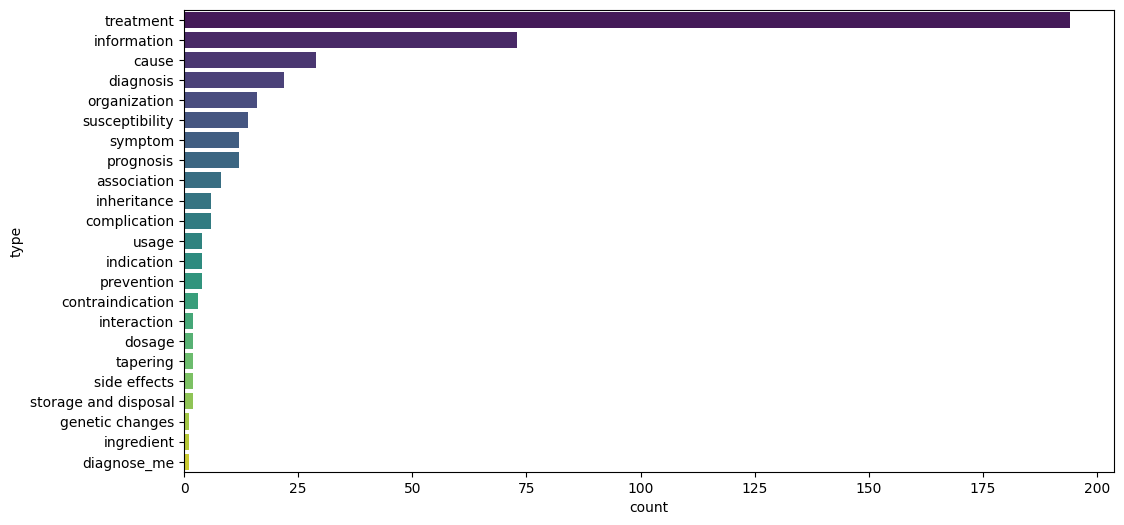

<ipython-input-42-970febe1a8f7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_test_type['type'], palette='viridis', order=df_test_type['type'].value_counts().index)


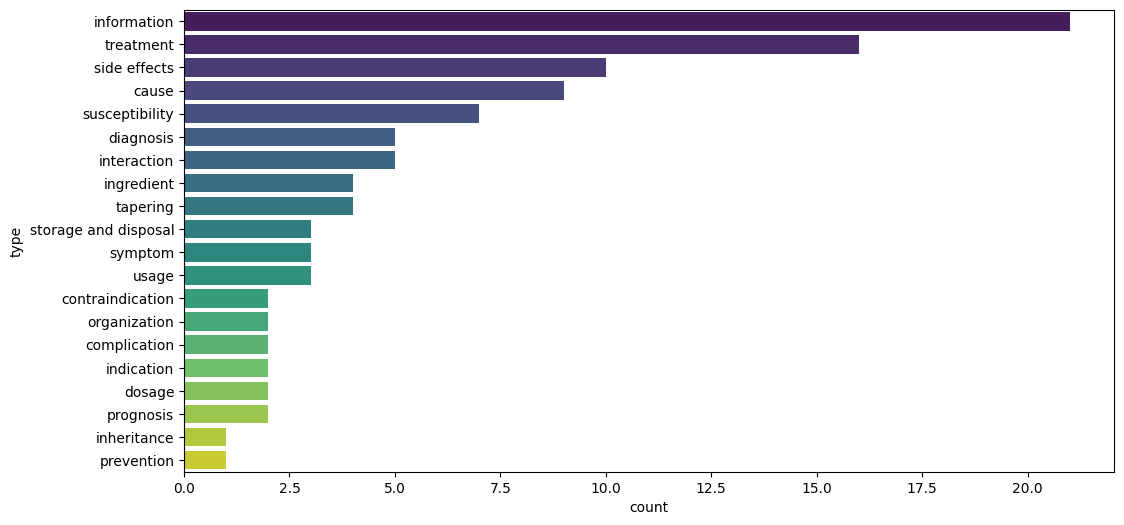

<ipython-input-42-970febe1a8f7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train_type['focus'], palette='viridis', order=df_train_type['focus'].value_counts().iloc[:20].index)


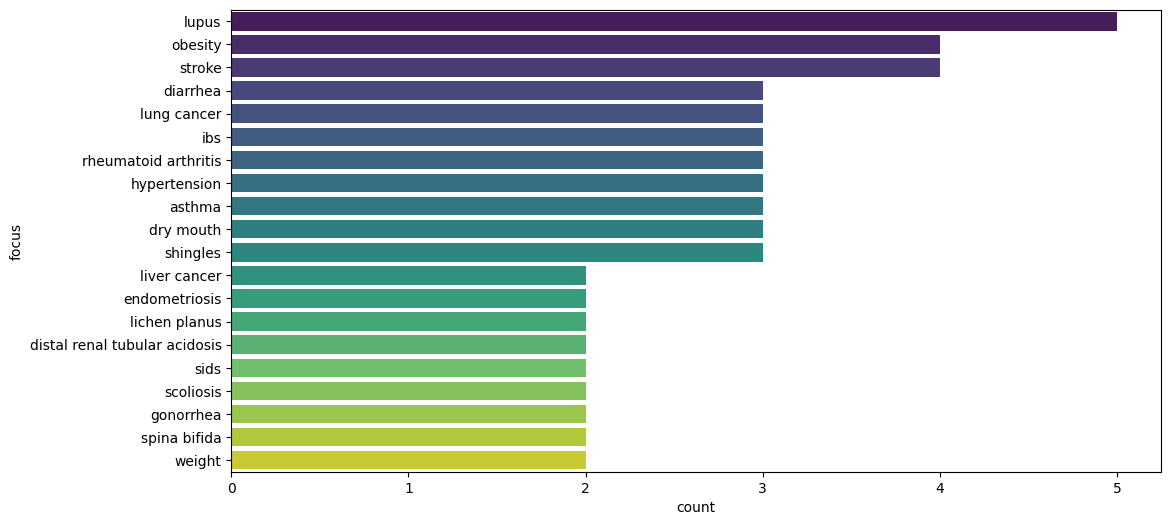

In [42]:
plt.figure(figsize=(12,6))
sns.countplot(y=df_train_type['type'], palette='viridis', order=df_train_type['type'].value_counts().index)
plt.show()
plt.figure(figsize=(12,6))
sns.countplot(y=df_test_type['type'], palette='viridis', order=df_test_type['type'].value_counts().index)
plt.show()
plt.figure(figsize=(12,6))
sns.countplot(y=df_train_type['focus'], palette='viridis', order=df_train_type['focus'].value_counts().iloc[:20].index)
plt.show()

Tenemos un conjunto de entrenamiento muy desbalanceado, con 195 preguntas del tipo 'treatment' y solo 1 de los tipos 'diagnose_me', 'ingredient' o 'genetic changes'. Vamos a reducir la cantidad de tipos de pregunta ya que podemos considerar que algunos tipos se solapan.

In [43]:
# Cambiamos algunos tipos de pregunta y dejamos los siguientes 9 tipos: Treatment, Information, Susceptibility, Prognosis, Symptom, Diagnosis, Cause, Organization, Drug Interaction
# Cambiamos diagnose_me, genetic changes, ingredient, contraindication, inheritance, prevention, complication, tapering, side effects, dosage, association, indication, interaction, storage and disposal, usage
# Conjunto de entrenamiento

df_train_type.loc[df_train_type['type']=='genetic changes', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='ingredient', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='complication', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='tapering', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='side effects', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='dosage', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='indication', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='storage and disposal', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='usage', 'type'] = 'information'
df_train_type.loc[df_train_type['type']=='contraindication', 'type'] = 'drug interaction'
df_train_type.loc[df_train_type['type']=='association', 'type'] = 'drug interaction'
df_train_type.loc[df_train_type['type']=='interaction', 'type'] = 'drug interaction'
df_train_type.loc[df_train_type['type']=='inheritance', 'type'] = 'cause'
df_train_type.loc[df_train_type['type']=='prevention', 'type'] = 'cause'
df_train_type.loc[df_train_type['type']=='diagnose_me', 'type'] = 'diagnosis'

# Conjunto de test
df_test_type.loc[df_test_type['type']=='genetic changes', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='ingredient', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='complication', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='tapering', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='side effects', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='dosage', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='indication', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='storage and disposal', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='usage', 'type'] = 'information'
df_test_type.loc[df_test_type['type']=='contraindication', 'type'] = 'drug interaction'
df_test_type.loc[df_test_type['type']=='association', 'type'] = 'drug interaction'
df_test_type.loc[df_test_type['type']=='interaction', 'type'] = 'drug interaction'
df_test_type.loc[df_test_type['type']=='inheritance', 'type'] = 'cause'
df_test_type.loc[df_test_type['type']=='prevention', 'type'] = 'cause'
df_test_type.loc[df_test_type['type']=='diagnose_me', 'type'] = 'diagnosis'

<ipython-input-44-b24676a8227e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train_type['type'], palette='viridis', order=df_train_type['type'].value_counts().index)


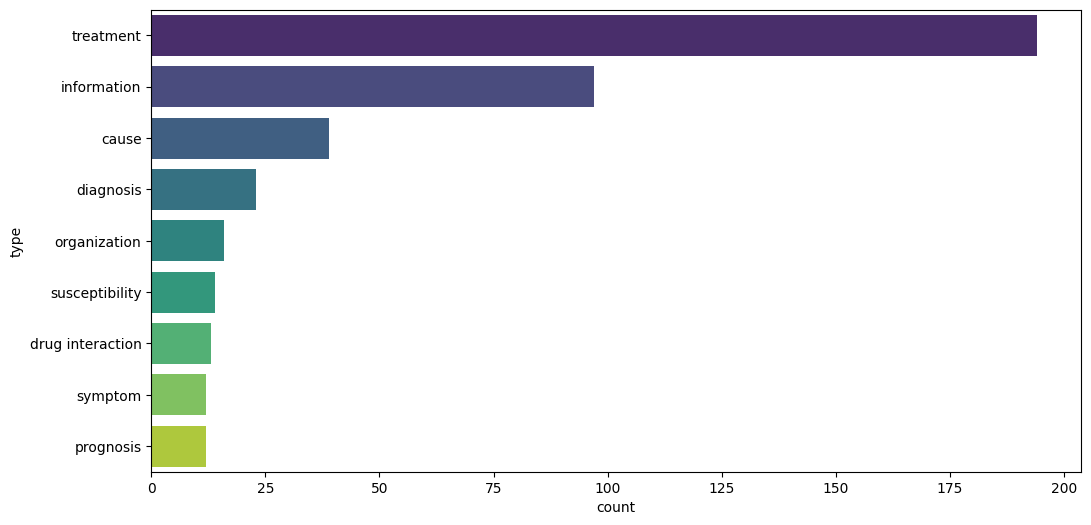

<ipython-input-44-b24676a8227e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_test_type['type'], palette='viridis', order=df_test_type['type'].value_counts().index)


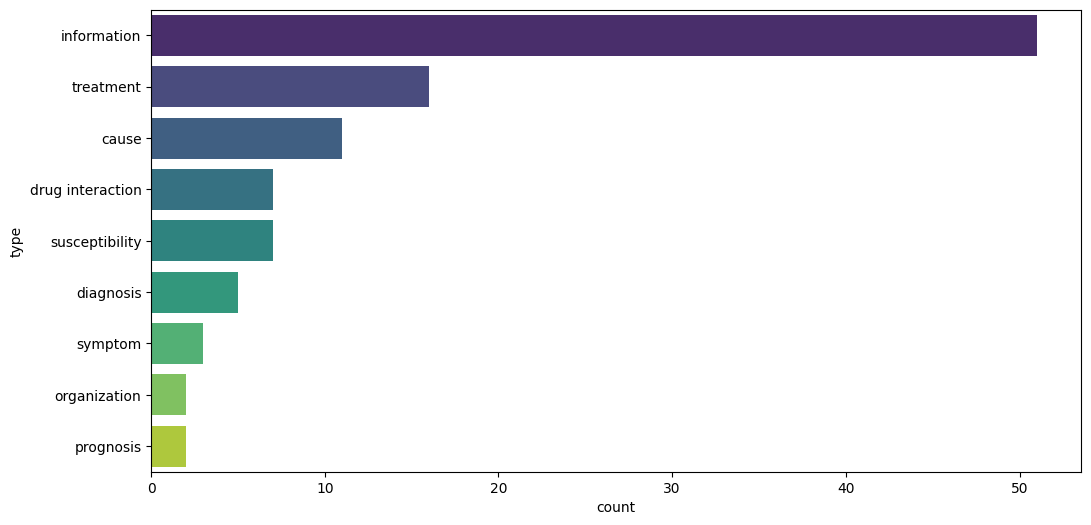

In [44]:
plt.figure(figsize=(12,6))
sns.countplot(y=df_train_type['type'], palette='viridis', order=df_train_type['type'].value_counts().index)
plt.show()
plt.figure(figsize=(12,6))
sns.countplot(y=df_test_type['type'], palette='viridis', order=df_test_type['type'].value_counts().index)
plt.show()

Seguimos con un gran desbalanceamiento de los datos. Luego los balancearemos para la clasificación.

## **Clasificación mediante Random Forest**

Vamos a entrenar un modelo de Random Forest para realizar la clasificación por tipo de pregunta. Probaremos con los datos sin balancear y balanceados.

Entrenamos un modelo Word2Vec para crear los embeddings.

In [45]:
# Tokenización y limpieza
texts = df_train_type['question_clean'].apply(preprocess_string).tolist()

# Entrenamos el modelo word2vec para vectorizar el texto
model_w2v = Word2Vec(sentences=texts, window=5, min_count=1, workers=-1)
model_w2v.save("/content/drive/MyDrive/TFB/models/word2vec.model")
word_vectors = model_w2v.wv

In [46]:
longitud = df_train_type['question_clean'].str.split()
long_max = longitud.str.len().max()

Vectorizamos el texto.

In [47]:
def vectorizar_texto(texto):
    vector_size = model_w2v.vector_size
    # Inicializar un vector de ceros
    vector = np.zeros(vector_size)
    # Contar las palabras que están en el vocabulario de Word2Vec
    count = 0
    for palabra in texto:
        if palabra in model_w2v.wv.key_to_index:
            vector += model_w2v.wv[palabra]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Aplicar la función de vectorización a los textos limpios
X_train = np.array([vectorizar_texto(texto) for texto in df_train_type['question_clean'].apply(preprocess_string)])
X_test = np.array([vectorizar_texto(texto) for texto in df_test_type['question_clean'].apply(preprocess_string)])
# Las etiquetas de las categorías
y_train = df_train_type.drop(columns=['question_clean', 'focus'])
y_test = df_test_type.drop(columns=['question_clean', 'focus'])

Creamos un conjunto de datos balanceado, realizando un submuestreo.

In [48]:
# Aplicamos un submuestreo para balancear las muestras
X_np = np.array(X_train)
y_np = np.array(y_train)

# Inicializar RandomUnderSampler
undersample = RandomUnderSampler(random_state=random_state)

# Aplicar submuestreo
X_train_resampled, y_train_resampled = undersample.fit_resample(X_np, y_np)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Definir el modelo Random Forest
modelo_rf_unbalanced = RandomForestClassifier(criterion='gini', n_estimators=130, min_samples_split=3, random_state=random_state, class_weight='balanced_subsample')
modelo_rf_balanced = RandomForestClassifier(criterion='gini', n_estimators=130, min_samples_split=3, random_state=random_state, class_weight='balanced')
# Entrenar el modelo
modelo_rf_balanced.fit(X_train_resampled, y_train_resampled)
modelo_rf_unbalanced.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=3,
                       n_estimators=130, random_state=42)

In [50]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = modelo_rf_unbalanced.predict(X_test)

# Evaluar el modelo
print("Entrenamiento con conjunto completo (desbalanceado)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Entrenamiento con conjunto completo (desbalanceado)
Accuracy: 0.25
Classification Report:
                   precision    recall  f1-score   support

           cause       0.40      0.18      0.25        11
       diagnosis       1.00      0.40      0.57         5
drug interaction       0.00      0.00      0.00         7
     information       0.83      0.10      0.18        51
    organization       0.00      0.00      0.00         2
       prognosis       0.00      0.00      0.00         2
  susceptibility       0.50      0.14      0.22         7
         symptom       1.00      0.33      0.50         3
       treatment       0.17      0.94      0.29        16

        accuracy                           0.25       104
       macro avg       0.43      0.23      0.22       104
    weighted avg       0.59      0.25      0.21       104



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = modelo_rf_balanced.predict(X_test)

# Evaluar el modelo
print("Entrenamiento con conjunto balanceado")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Entrenamiento con conjunto balanceado
Accuracy: 0.2403846153846154
Classification Report:
                   precision    recall  f1-score   support

           cause       0.21      0.27      0.24        11
       diagnosis       0.33      0.40      0.36         5
drug interaction       0.06      0.14      0.09         7
     information       0.61      0.22      0.32        51
    organization       0.12      0.50      0.20         2
       prognosis       0.08      0.50      0.14         2
  susceptibility       0.25      0.43      0.32         7
         symptom       0.11      0.33      0.17         3
       treatment       0.22      0.12      0.16        16

        accuracy                           0.24       104
       macro avg       0.22      0.32      0.22       104
    weighted avg       0.40      0.24      0.26       104



Guardamos el modelo entrenado con los datos balanceados, con el que hemos conseguido una precisión del 24%.

In [53]:
joblib.dump(modelo_rf_balanced, '/content/drive/MyDrive/TFB/models/model_classification_balanced.joblib')

['/content/drive/MyDrive/TFB/models/model_classification_balanced.joblib']

## **Clasificación mediante redes neuronales**

Ahora vamos a probar a realizar la clasificación mediante una red neuronal, para comprobar si obtenemos mejores resultados.

In [ ]:
# Creamos variables dummy
separated_types_train = df_train_type['type'].str.get_dummies()
separated_types_test = df_test_type['type'].str.get_dummies()

# Concatenar los DataFrames
df_train_encoded_type = pd.concat([df_train_type, separated_types_train], axis=1)
df_test_encoded_type = pd.concat([df_test_type, separated_types_test], axis=1)

# Eliminar la columna original 'type'
df_train_encoded_type.drop(columns=['type'], inplace=True)
df_test_encoded_type.drop(columns=['type'], inplace=True)

In [ ]:
# Tokenizamos los textos y los convertimos a secuencias (asignamos X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train_encoded_type['question_clean'].values)
sequences = tokenizer.texts_to_sequences(df_train_encoded_type['question_clean'].values)
sequences_test = tokenizer.texts_to_sequences(df_test_encoded_type['question_clean'].values)
X = pad_sequences(sequences, maxlen=long_max)
y = df_train_encoded_type.drop(columns=['question_clean', 'focus'])
X_test = pad_sequences(sequences_test, maxlen=long_max)
y_test = df_test_encoded_type.drop(columns=['question_clean', 'focus'])

In [ ]:
# Suponiendo que X_train y y_train son DataFrames de Pandas
X_np = np.array(X)
y_np = np.array(y)

# Inicializar RandomUnderSampler
undersample = RandomUnderSampler(random_state=random_state)

# Aplicar submuestreo
X_resampled, y_resampled = undersample.fit_resample(X_np, y_np)

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('\nPadded text:', X_train[80])
print('\nPadded text Length: ', len(X_train[80]))


Padded text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1098
  502  150 2967  262 2968 2969  243 2970 2971  129  512 2972  148  449
    5   23  276   69 2973    5   23   45 2974  148 2975  330   69   15
   57  357 2976 2977  353  788 2978  360   93   22  905  776  188 2979
    3  112 1163   12  650  651]

Padded text Length:  132


In [ ]:
# Preparar la matriz de embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word_vectors.key_to_index:  # Updated to use .key_to_index
        embedding_matrix[i] = word_vectors.get_vector(word)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00053623,  0.00023643,  0.00510335, ..., -0.00704156,
         0.00090146,  0.00639253],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
n_categorias_type = len(df_train_encoded_type.drop(columns=['question_clean', 'focus']).columns)
n_categorias_type

9

Probamos con redes de una o dos capas, con distinto número de neuronas.

In [ ]:
clear_session()
classifier_type_dense512 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(512, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense256 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(256, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense128 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense64 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense512_256 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(512, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(256, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense256_128 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(256, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dense128_64 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])

In [ ]:
# Compilar el modelo
print('Entrenando modelo dense512.')
classifier_type_dense512.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense512 = classifier_type_dense512.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense256.')
classifier_type_dense256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense256 = classifier_type_dense256.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense128.')
classifier_type_dense128.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense128 = classifier_type_dense128.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense64.')
classifier_type_dense64.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense64 = classifier_type_dense64.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense512_256.')
classifier_type_dense512_256.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense512_256 = classifier_type_dense512_256.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense256_128.')
classifier_type_dense256_128.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense256_128 = classifier_type_dense256_128.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)
print('Entrenando modelo dense128_64.')
classifier_type_dense128_64.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_dense128_64 = classifier_type_dense128_64.fit(X_train, y_train, epochs=50, validation_data=[X_val, y_val], verbose=0)


Entrenando modelo dense512.
Entrenando modelo dense256.
Entrenando modelo dense128.
Entrenando modelo dense64.
Entrenando modelo dense512_256.
Entrenando modelo dense256_128.
Entrenando modelo dense128_64.


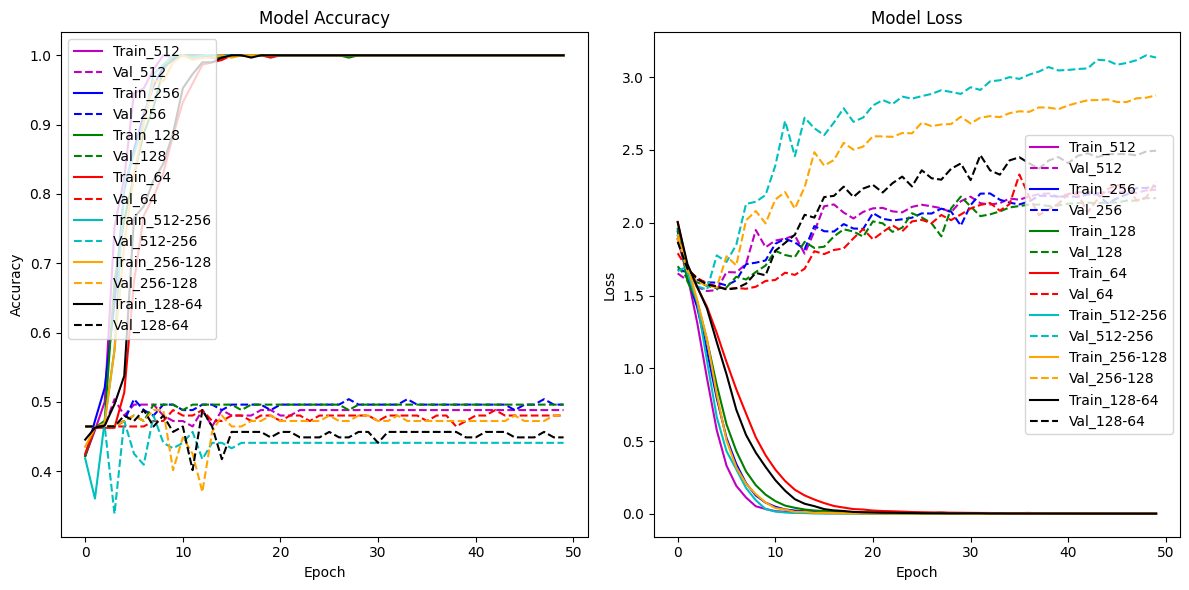

In [ ]:
# Colores distintivos para cada grupo de tamaño de lote
colors = ['m', 'b', 'g', 'r', 'c', 'orange', 'black']
labels = ['512', '256', '128', '64', '512-256', '256-128', '128-64']

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
for i, history in enumerate([history_classifier_type_dense512.history, history_classifier_type_dense256.history, history_classifier_type_dense128.history, history_classifier_type_dense64.history,
                             history_classifier_type_dense512_256.history, history_classifier_type_dense256_128.history, history_classifier_type_dense128_64.history]):
    plt.plot(history['accuracy'], color=colors[i], linestyle='-')
    plt.plot(history['val_accuracy'], color=colors[i], linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_512', 'Val_512', 'Train_256', 'Val_256', 'Train_128', 'Val_128', 'Train_64', 'Val_64', 'Train_512-256', 'Val_512-256', 'Train_256-128', 'Val_256-128',
            'Train_128-64', 'Val_128-64'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_classifier_type_dense512.history, history_classifier_type_dense256.history, history_classifier_type_dense128.history, history_classifier_type_dense64.history,
                             history_classifier_type_dense512_256.history, history_classifier_type_dense256_128.history, history_classifier_type_dense128_64.history]):
    plt.plot(history['loss'], color=colors[i], linestyle='-')
    plt.plot(history['val_loss'], color=colors[i], linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_512', 'Val_512', 'Train_256', 'Val_256', 'Train_128', 'Val_128', 'Train_64', 'Val_64', 'Train_512-256', 'Val_512-256', 'Train_256-128', 'Val_256-128',
            'Train_128-64', 'Val_128-64'])
plt.tight_layout()
plt.show()

Nos quedamos con la red de una capa con 128 neuronas.

### Tamaño del batch

Probamos distintos tamaños del batch.

In [ ]:
clear_session()
classifier_type_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_classifier_type_batch_8 = classifier_type_batch.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=[X_val, y_val], verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 8: {round(duration,2)} segundos")

clear_session()
classifier_type_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_classifier_type_batch_16 = classifier_type_batch.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=[X_val, y_val], verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 16: {round(duration,2)} segundos")

clear_session()
classifier_type_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_classifier_type_batch_32 = classifier_type_batch.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=[X_val, y_val], verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 32: {round(duration,2)} segundos")

clear_session()
classifier_type_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_classifier_type_batch_64 = classifier_type_batch.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=[X_val, y_val], verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 64: {round(duration,2)} segundos")

clear_session()
classifier_type_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_batch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
history_classifier_type_batch_128 = classifier_type_batch.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=[X_val, y_val], verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 128: {round(duration,2)} segundos")

Tiempo de ejecución del entrenamiento con batch 8: 58.28 segundos
Tiempo de ejecución del entrenamiento con batch 16: 38.48 segundos
Tiempo de ejecución del entrenamiento con batch 32: 32.17 segundos
Tiempo de ejecución del entrenamiento con batch 64: 32.96 segundos
Tiempo de ejecución del entrenamiento con batch 128: 22.62 segundos


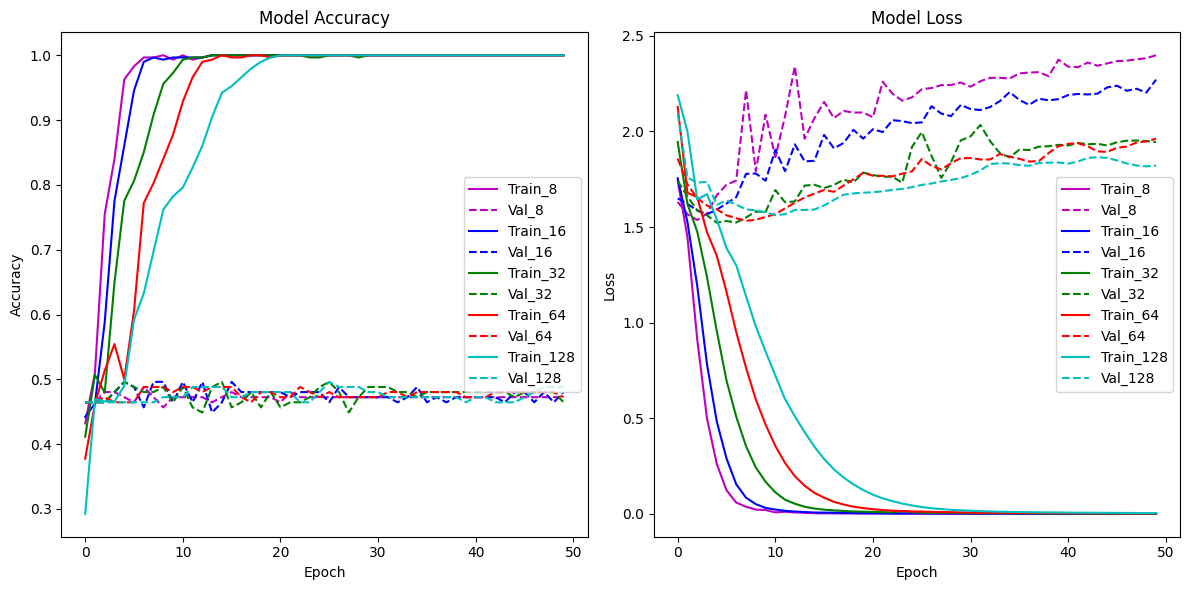

In [ ]:
# Colores distintivos para cada grupo de tamaño de lote
colors = ['m', 'b', 'g', 'r', 'c']
labels = ['8', '16', '32', '64', '128']

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
for i, history in enumerate([history_classifier_type_batch_8.history, history_classifier_type_batch_16.history, history_classifier_type_batch_32.history, history_classifier_type_batch_64.history, history_classifier_type_batch_128.history]):
    plt.plot(history['accuracy'], color=colors[i], linestyle='-')
    plt.plot(history['val_accuracy'], color=colors[i], linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_8', 'Val_8', 'Train_16', 'Val_16', 'Train_32', 'Val_32', 'Train_64', 'Val_64', 'Train_128', 'Val_128'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_classifier_type_batch_8.history, history_classifier_type_batch_16.history, history_classifier_type_batch_32.history, history_classifier_type_batch_64.history, history_classifier_type_batch_128.history]):
    plt.plot(history['loss'], color=colors[i], linestyle='-')
    plt.plot(history['val_loss'], color=colors[i], linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_8', 'Val_8', 'Train_16', 'Val_16', 'Train_32', 'Val_32', 'Train_64', 'Val_64', 'Train_128', 'Val_128'])
plt.tight_layout()
plt.show()

Nos quedamos con batch_size=128.

### Regularización

In [ ]:
clear_session()
classifier_type_batchNorm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    BatchNormalization(),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])

# Printear la arquitectura del modelo
classifier_type_batchNorm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 100)          312500    
                                                                 
 flatten (Flatten)           (None, 13200)             0         
                                                                 
 dense (Dense)               (None, 128)               1689728   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 2003901 (7.64 MB)
Trainable params: 2003645 (7.64 MB)
Non-trainable params: 256 (1.00 KB)
__________________

In [ ]:
# Compilamos y entrenamos el modelo
classifier_type_batchNorm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_classifier_type_batchNorm = classifier_type_batchNorm.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=[X_val, y_val])

Epoch 1/50
3/3 [==============================] - 3s 248ms/step - loss: 2.1795 - accuracy: 0.1463 - val_loss: 2.1669 - val_accuracy: 0.4646
Epoch 2/50
3/3 [==============================] - 1s 170ms/step - loss: 1.5671 - accuracy: 0.8435 - val_loss: 2.0973 - val_accuracy: 0.4646
Epoch 3/50
3/3 [==============================] - 0s 161ms/step - loss: 0.8351 - accuracy: 0.9286 - val_loss: 2.0077 - val_accuracy: 0.4646
Epoch 4/50
3/3 [==============================] - 1s 168ms/step - loss: 0.3408 - accuracy: 0.9762 - val_loss: 1.9901 - val_accuracy: 0.4646
Epoch 5/50
3/3 [==============================] - 0s 146ms/step - loss: 0.1801 - accuracy: 0.9762 - val_loss: 1.9812 - val_accuracy: 0.4646
Epoch 6/50
3/3 [==============================] - 0s 157ms/step - loss: 0.0832 - accuracy: 0.9932 - val_loss: 2.0084 - val_accuracy: 0.4646
Epoch 7/50
3/3 [==============================] - 0s 150ms/step - loss: 0.0431 - accuracy: 1.0000 - val_loss: 2.0496 - val_accuracy: 0.4646
Epoch 8/50
3/3 [====

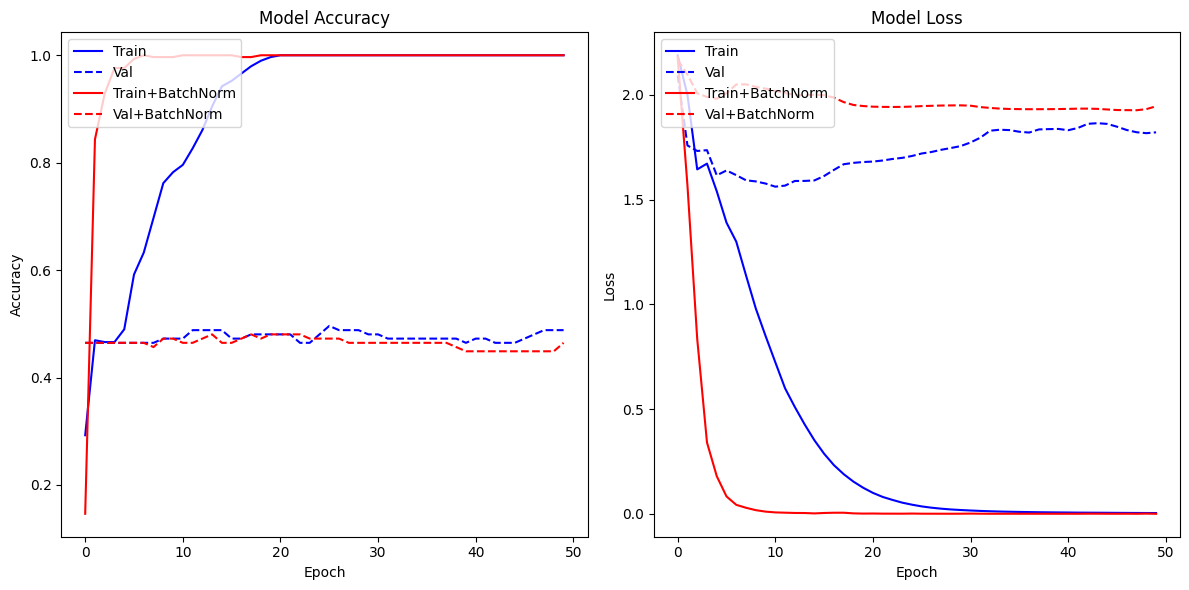

In [ ]:
# Dibujamos las curvas de precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+BatchNorm', 'Val+BatchNorm']
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_batchNorm.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Dibujamos las curvas de pérdidas de entrenamiento y validación
plt.subplot(1, 2, 2)
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_batchNorm.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Añadimos dropout.

In [ ]:
clear_session()
classifier_type_dropout_02 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_dropout_05 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])

In [ ]:
# Compilamos y entrenamos los modelos
classifier_type_dropout_02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_type_dropout_05.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_classifier_type_dropout_02 = classifier_type_dropout_02.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=[X_val, y_val])
history_classifier_type_dropout_05 = classifier_type_dropout_05.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=[X_val, y_val])

Epoch 1/50
3/3 [==============================] - 6s 419ms/step - loss: 2.1858 - accuracy: 0.1701 - val_loss: 2.1742 - val_accuracy: 0.2992
Epoch 2/50
3/3 [==============================] - 1s 244ms/step - loss: 1.5924 - accuracy: 0.8639 - val_loss: 2.1237 - val_accuracy: 0.4646
Epoch 3/50
3/3 [==============================] - 1s 253ms/step - loss: 0.9133 - accuracy: 0.9524 - val_loss: 2.0482 - val_accuracy: 0.4646
Epoch 4/50
3/3 [==============================] - 1s 485ms/step - loss: 0.4262 - accuracy: 0.9490 - val_loss: 2.0350 - val_accuracy: 0.4646
Epoch 5/50
3/3 [==============================] - 1s 222ms/step - loss: 0.2132 - accuracy: 0.9830 - val_loss: 2.0660 - val_accuracy: 0.4488
Epoch 6/50
3/3 [==============================] - 0s 145ms/step - loss: 0.1425 - accuracy: 0.9796 - val_loss: 2.0990 - val_accuracy: 0.3386
Epoch 7/50
3/3 [==============================] - 0s 142ms/step - loss: 0.0801 - accuracy: 0.9966 - val_loss: 2.1290 - val_accuracy: 0.2913
Epoch 8/50
3/3 [====

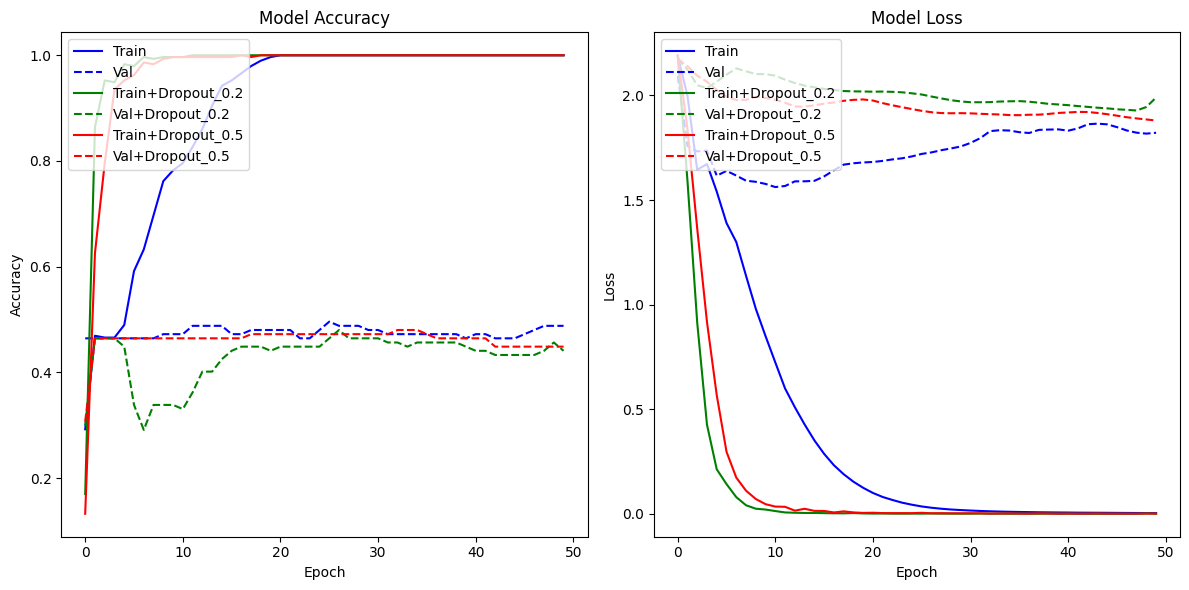

In [ ]:
# Dibujamos las curvas de precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'g', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+Dropout_0.2', 'Val+Dropout_0.2', 'Train+Dropout_0.5', 'Val+Dropout_0.5']
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_dropout_02.history, history_classifier_type_dropout_05.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Dibujamos las curvas de pérdidas de entrenamiento y validación
plt.subplot(1, 2, 2)
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_dropout_02.history, history_classifier_type_dropout_05.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

No añadimos regularización ni dropout.

### Early Stopping

Probamos a añadir early stopping.

In [ ]:
clear_session()
classifier_type_early_stopping = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))
])

classifier_type_early_stopping.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 100)          312500    
                                                                 
 flatten (Flatten)           (None, 13200)             0         
                                                                 
 dense (Dense)               (None, 128)               1689728   
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 2003389 (7.64 MB)
Trainable params: 2003389 (7.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
classifier_type_early_stopping.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
history_classifier_type_early_stopping = classifier_type_early_stopping.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=[X_val, y_val])

Epoch 1/50
3/3 [==============================] - 2s 316ms/step - loss: 3.5657 - accuracy: 0.3197 - val_loss: 3.4368 - val_accuracy: 0.4646
Epoch 2/50
3/3 [==============================] - 0s 164ms/step - loss: 3.3379 - accuracy: 0.4694 - val_loss: 3.0787 - val_accuracy: 0.4646
Epoch 3/50
3/3 [==============================] - 0s 69ms/step - loss: 2.9697 - accuracy: 0.4626 - val_loss: 2.9718 - val_accuracy: 0.4646
Epoch 4/50
3/3 [==============================] - 0s 115ms/step - loss: 2.8649 - accuracy: 0.4660 - val_loss: 2.9008 - val_accuracy: 0.4646
Epoch 5/50
3/3 [==============================] - 1s 188ms/step - loss: 2.7366 - accuracy: 0.4898 - val_loss: 2.8253 - val_accuracy: 0.4646
Epoch 6/50
3/3 [==============================] - 0s 110ms/step - loss: 2.6086 - accuracy: 0.5510 - val_loss: 2.7869 - val_accuracy: 0.4646
Epoch 7/50
3/3 [==============================] - 0s 117ms/step - loss: 2.4884 - accuracy: 0.5578 - val_loss: 2.7525 - val_accuracy: 0.4646
Epoch 8/50
3/3 [=====

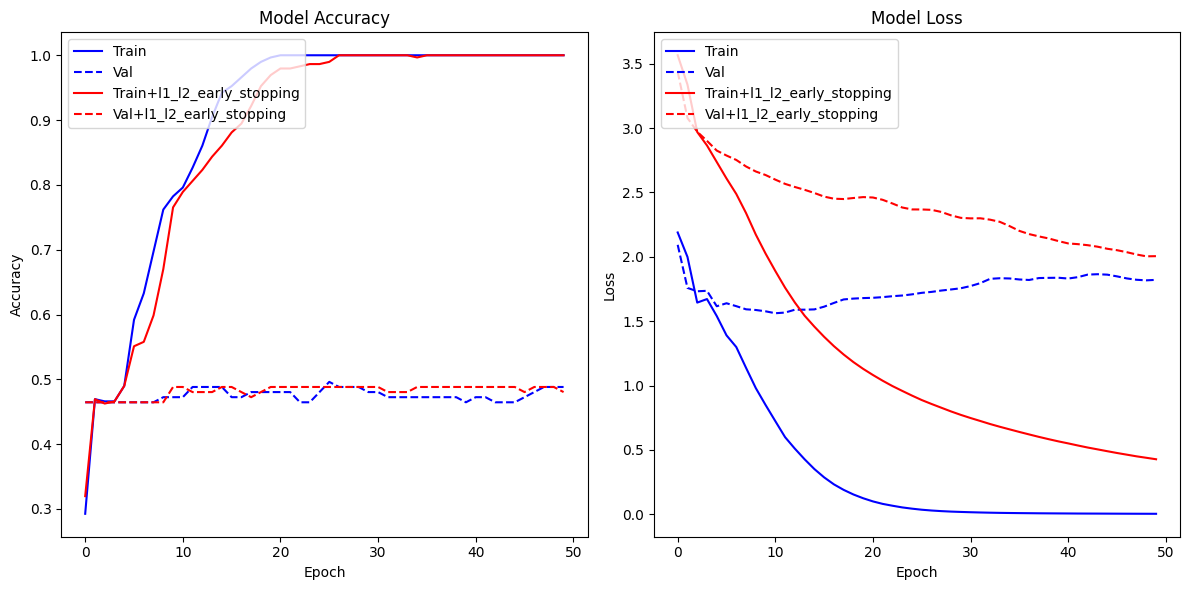

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+l1_l2_early_stopping', 'Val+l1_l2_early_stopping']
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_early_stopping.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_classifier_type_batch_128.history, history_classifier_type_early_stopping.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

No añadimos early stopping.

### Optimizadores

In [ ]:
def lr_schedule(epoch, lr):
    """Función de decaimiento de la tasa de aprendizaje que puedes ajustar según tus necesidades."""
    if epoch > 10:
        lr = lr * np.exp(-0.1)
    return lr

optimizers = {
    'SGD': SGD(learning_rate=0.01),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Adam': Adam(learning_rate=0.001),
}

histories = {}

for name, optimizer in optimizers.items():
    print(f"Entrenando con el optimizador: {name}")
    clear_session()
    classifier_type_optimizer = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
        Flatten(),
        Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
        Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
        ])

    # Compilar el modelo con el optimizador actual
    classifier_type_optimizer.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo y guardar el historial
    history = classifier_type_optimizer.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=[X_val, y_val])
    histories[name] = history

# Ahora `histories` contiene los historiales de entrenamiento para cada optimizador

Entrenando con el optimizador: SGD
Epoch 1/50
5/5 [==============================] - 1s 131ms/step - loss: 2.1901 - accuracy: 0.3469 - val_loss: 2.1739 - val_accuracy: 0.4646
Epoch 2/50
5/5 [==============================] - 1s 92ms/step - loss: 2.1643 - accuracy: 0.4626 - val_loss: 2.1457 - val_accuracy: 0.4646
Epoch 3/50
5/5 [==============================] - 1s 118ms/step - loss: 2.1356 - accuracy: 0.4626 - val_loss: 2.1160 - val_accuracy: 0.4646
Epoch 4/50
5/5 [==============================] - 0s 122ms/step - loss: 2.1047 - accuracy: 0.4626 - val_loss: 2.0823 - val_accuracy: 0.4646
Epoch 5/50
5/5 [==============================] - 1s 109ms/step - loss: 2.0693 - accuracy: 0.4626 - val_loss: 2.0437 - val_accuracy: 0.4646
Epoch 6/50
5/5 [==============================] - 0s 100ms/step - loss: 2.0285 - accuracy: 0.4626 - val_loss: 1.9986 - val_accuracy: 0.4646
Epoch 7/50
5/5 [==============================] - 1s 115ms/step - loss: 1.9809 - accuracy: 0.4626 - val_loss: 1.9451 - val_acc

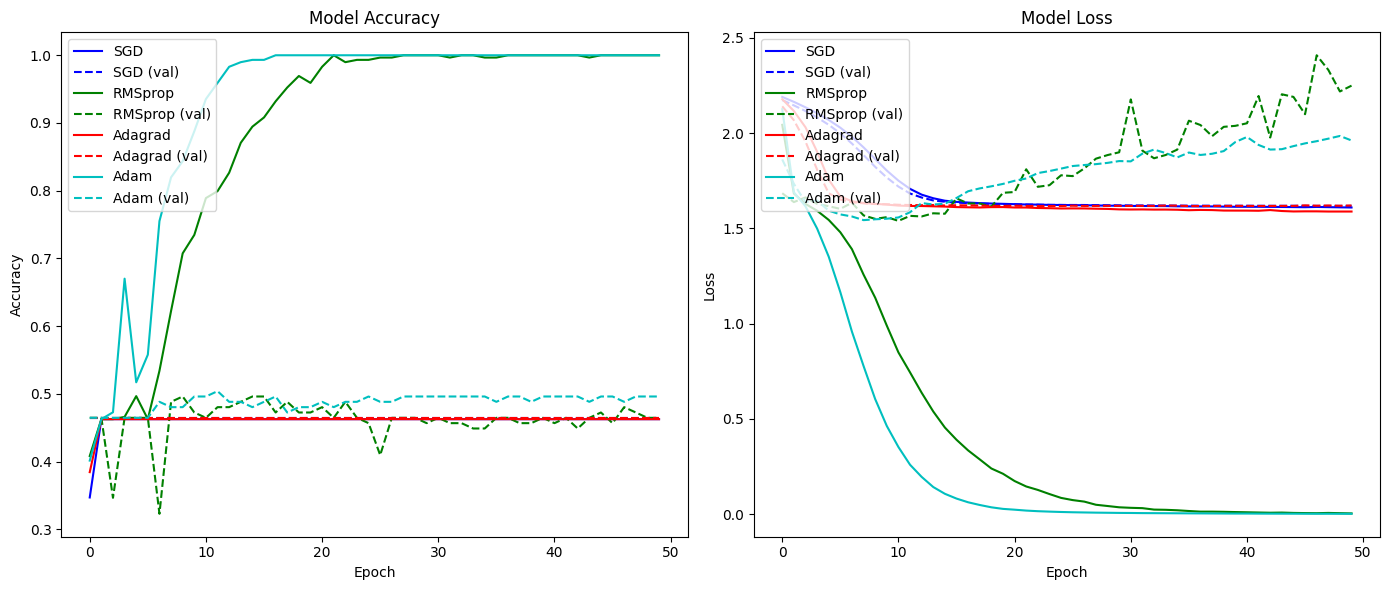

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Gráfica de precisión
plt.subplot(1, 2, 1)
colors = ['b', 'g', 'r', 'c']  # Colores para grupos
for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history['accuracy'], color=colors[i], label=f'{name}')
    plt.plot(history.history['val_accuracy'], '--', color=colors[i], label=f'{name} (val)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Gráfica de pérdida
plt.subplot(1, 2, 2)
for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history['loss'], color=colors[i], label=f'{name}')
    plt.plot(history.history['val_loss'], '--', color=colors[i], label=f'{name} (val)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Nos quedamos con el optimizador Adam.

### Compilación de la red final

La red que vamos a estudiar tiene una capa de 128 neuronas, entrenada con un batch_size de 128.

In [ ]:
clear_session()
classifier_type_final = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=long_max, trainable=True),
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),
    Dense(n_categorias_type, kernel_initializer=GlorotUniform(), activation='softmax')
])
classifier_type_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_classifier_type_final = classifier_type_final.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=[X_val, y_val])

Epoch 1/25
3/3 [==============================] - 1s 204ms/step - loss: 2.1877 - accuracy: 0.2993 - val_loss: 2.0821 - val_accuracy: 0.4646
Epoch 2/25
3/3 [==============================] - 0s 117ms/step - loss: 1.9813 - accuracy: 0.4694 - val_loss: 1.7278 - val_accuracy: 0.4646
Epoch 3/25
3/3 [==============================] - 0s 127ms/step - loss: 1.6581 - accuracy: 0.4626 - val_loss: 1.7047 - val_accuracy: 0.4646
Epoch 4/25
3/3 [==============================] - 0s 76ms/step - loss: 1.5949 - accuracy: 0.4660 - val_loss: 1.6578 - val_accuracy: 0.4646
Epoch 5/25
3/3 [==============================] - 0s 110ms/step - loss: 1.4959 - accuracy: 0.6837 - val_loss: 1.6371 - val_accuracy: 0.4724
Epoch 6/25
3/3 [==============================] - 0s 111ms/step - loss: 1.3937 - accuracy: 0.7075 - val_loss: 1.6193 - val_accuracy: 0.4646
Epoch 7/25
3/3 [==============================] - 0s 112ms/step - loss: 1.2639 - accuracy: 0.6429 - val_loss: 1.5916 - val_accuracy: 0.4724
Epoch 8/25
3/3 [=====

In [ ]:
# Suponiendo que ya tienes un modelo entrenado y datos de prueba
# Ejemplo de predicciones del modelo
y_pred = classifier_type_final.predict(X_test, batch_size=16)

# Redondear las predicciones a 0 o 1 (puedes ajustar esto según tu umbral)
# y_pred_binary = np.round(y_pred)
max_indices = np.argmax(y_pred, axis=1)
y_pred_binary = np.zeros_like(y_pred)
for i, index in enumerate(max_indices):
    y_pred_binary[i, index] = 1

# Calcular métricas para cada categoría
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary, average=None)
recall = recall_score(y_test, y_pred_binary, average=None)
f1 = f1_score(y_test, y_pred_binary, average=None)

# Mostrar las métricas
print(f'Accuracy: {accuracy:.4f}')
print('Precision:')
print(precision)
print('Recall:')
print(recall)
print('F1-score:')
print(f1)

7/7 [==============================] - 0s 2ms/step
Accuracy: 0.2500
Precision:
[0.33333333 1.         0.         0.6        0.         0.
 0.5        0.5        0.17857143]
Recall:
[0.09090909 0.4        0.         0.11764706 0.         0.
 0.14285714 0.33333333 0.9375    ]
F1-score:
[0.14285714 0.57142857 0.         0.19672131 0.         0.
 0.22222222 0.4        0.3       ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classes = df_train_encoded_type.drop(columns=['question_clean', 'focus']).columns.to_list()
data = {
    'Tipo': classes,
    'Precision': precision.round(2),
    'Recall': recall.round(2),
    'F1-score': f1.round(2)
}
df = pd.DataFrame(data)

print(df)

               Tipo  Precision  Recall  F1-score
0             cause       0.33    0.09      0.14
1         diagnosis       1.00    0.40      0.57
2  drug interaction       0.00    0.00      0.00
3       information       0.60    0.12      0.20
4      organization       0.00    0.00      0.00
5         prognosis       0.00    0.00      0.00
6    susceptibility       0.50    0.14      0.22
7           symptom       0.50    0.33      0.40
8         treatment       0.18    0.94      0.30


Obtenemos un resultado similar al conseguido con Random Forest, por lo que nos quedamos con el primero por su sencillez.

## **Extracción de keywords (focus)**

Para extraer el focus de las preguntas vamos a refinar un modelo preentrenado de Huggingface, Voicelab/vlt5-base-keywords. Lo refinaremos con las preguntas completas, sin eliminar stopwords.

In [54]:
model_focus = T5ForConditionalGeneration.from_pretrained("Voicelab/vlt5-base-keywords")
tokenizer_focus = T5Tokenizer.from_pretrained("Voicelab/vlt5-base-keywords")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Creamos los dataframes de entrenamiento y test con las preguntas completas y el focus.

In [55]:
df_train_focus = df_train.loc[:, ['question', 'focus']]
df_test_focus = df_test.loc[:, ['question', 'focus']]
df_train_focus = df_train_focus.drop_duplicates(ignore_index=True)
df_test_focus = df_test_focus.drop_duplicates(ignore_index=True)

In [56]:
dataset_train_focus = Dataset.from_pandas(df_train_focus)
dataset_test_focus = Dataset.from_pandas(df_test_focus)

In [57]:
long_question = df_train_focus['question'].str.split()
long_max_question = int(long_question.str.len().max())
long_focus = df_train_focus['focus'].str.split()
long_max_focus = int(long_focus.str.len().max())

Tokenizamos los textos.

In [58]:
def preprocess_data(examples):
    inputs = [f"Keywords: {text}" for text in examples['question']]
    model_inputs = tokenizer_focus(inputs, max_length=long_max_question, truncation=True, padding='max_length')

    with tokenizer_focus.as_target_tokenizer():
        labels = tokenizer_focus(examples['focus'], max_length=long_max_focus, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_dataset_train = dataset_train_focus.map(preprocess_data, batched=True)
tokenized_dataset_test = dataset_test_focus.map(preprocess_data, batched=True)

Map:   0%|          | 0/432 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Separamos en entrenamiento y validación y refinamos el modelo.

In [59]:
# Dividir el dataset en 70% entrenamiento y 30% evaluación
train_val_focus = tokenized_dataset_train.train_test_split(test_size=0.3)
datasets_train_val = DatasetDict({
    'train': train_val_focus['train'],
    'validation': train_val_focus['test']
})

In [60]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=8,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model_focus,
    args=training_args,
    train_dataset=datasets_train_val['train'],
    eval_dataset=datasets_train_val['validation'],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,4.371347
2,No log,2.624380
3,No log,4.809059
4,No log,1.814245
5,No log,1.482208
6,No log,1.429242
7,4.310800,1.259092
8,4.310800,1.241894


TrainOutput(global_step=608, training_loss=3.9645151841013053, metrics={'train_runtime': 349.2594, 'train_samples_per_second': 6.917, 'train_steps_per_second': 1.741, 'total_flos': 741031378550784.0, 'train_loss': 3.9645151841013053, 'epoch': 8.0})

In [61]:
task_prefix = "Keywords: "
inputs = df_test_focus['question'].to_list()
labels_test = df_test_focus['focus'].to_list()
i = 0
correct_keywords = 0
for sample in inputs:
    input_sequences = [task_prefix + sample]
    input_ids = tokenizer_focus(
        input_sequences, return_tensors="pt", truncation=True
    ).input_ids.to(device)
    output = model_focus.generate(input_ids, no_repeat_ngram_size=3, num_beams=4)
    predicted = tokenizer_focus.decode(output[0], skip_special_tokens=True)
    label_i = labels_test[i].split(', ')
    if predicted in label_i:
      correct_keywords += 1
    i += 1
    print(f'Pregunta {i} de {len(inputs)}')
correct_keywords_perc = correct_keywords / i
print(f'Porcentaje de focus correctos: {correct_keywords_perc}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Pregunta 1 de 104
Pregunta 2 de 104
Pregunta 3 de 104
Pregunta 4 de 104
Pregunta 5 de 104
Pregunta 6 de 104
Pregunta 7 de 104
Pregunta 8 de 104
Pregunta 9 de 104
Pregunta 10 de 104
Pregunta 11 de 104
Pregunta 12 de 104
Pregunta 13 de 104
Pregunta 14 de 104
Pregunta 15 de 104
Pregunta 16 de 104
Pregunta 17 de 104
Pregunta 18 de 104
Pregunta 19 de 104
Pregunta 20 de 104
Pregunta 21 de 104
Pregunta 22 de 104
Pregunta 23 de 104
Pregunta 24 de 104
Pregunta 25 de 104
Pregunta 26 de 104
Pregunta 27 de 104
Pregunta 28 de 104
Pregunta 29 de 104
Pregunta 30 de 104
Pregunta 31 de 104
Pregunta 32 de 104
Pregunta 33 de 104
Pregunta 34 de 104
Pregunta 35 de 104
Pregunta 36 de 104
Pregunta 37 de 104
Pregunta 38 de 104
Pregunta 39 de 104
Pregunta 40 de 104
Pregunta 41 de 104
Pregunta 42 de 104
Pregunta 43 de 104
Pregunta 44 de 104
Pregunta 45 de 104
Pregunta 46 de 104
Pregunta 47 de 104
Pregunta 48 de 104
Pregunta 49 de 104
Pregunta 50 de 104
Pregunta 51 de 104
Pregunta 52 de 104
Pregunta 53 de 104
Pr

Predecimos correctamente el 37.5% de los focus. En los restantes, a veces se incluye alguna palabra extra que no aparece en el focus real.

In [ ]:
model_focus.save_pretrained('/content/drive/MyDrive/TFB/models/model_focus')
tokenizer_focus.save_pretrained('/content/drive/MyDrive/TFB/models/model_focus')

('/content/drive/MyDrive/TFB/models/model_focus/tokenizer_config.json',
 '/content/drive/MyDrive/TFB/models/model_focus/special_tokens_map.json',
 '/content/drive/MyDrive/TFB/models/model_focus/spiece.model',
 '/content/drive/MyDrive/TFB/models/model_focus/added_tokens.json')

## **Modelo para responder a las preguntas**

Vamos a refinar el modelo distilgpt2 para generar las respuestas a las preguntas. Lo refinaremos con las preguntas modificadas a partir de su tipo y su focus.

In [ ]:
model_name = "distilgpt2"
model_gpt = GPT2LMHeadModel.from_pretrained(model_name).to(device)

In [ ]:
tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Creamos las preguntas modificadas.

In [ ]:
df_train['question_refor'] = 'can you give me ' + df_train['type'] + ' of ' + df_train['focus'] + '?'
df_train_QA = df_train.loc[:, ['question_refor', 'answer']]

questions = df_train_QA['question_refor'].tolist()
answers = df_train_QA['answer'].tolist()

# Concatenar preguntas y respuestas para el entrenamiento
data = [f"Question: {q} Answer: {a}" for q, a in zip(questions, answers)]

# Tokenización
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
inputs = tokenizer_gpt(data, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Crear un Dataset personalizado
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = QADataset(inputs)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=500,
    logging_dir="./logs",
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer_gpt,
    mlm=False,
)

Refinamos el modelo.

In [ ]:
trainer = Trainer(
    model=model_gpt,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

trainer.train()

Step,Training Loss
500,2.744000


TrainOutput(global_step=951, training_loss=2.5926013068069795, metrics={'train_runtime': 204.9579, 'train_samples_per_second': 9.28, 'train_steps_per_second': 4.64, 'total_flos': 248493209812992.0, 'train_loss': 2.5926013068069795, 'epoch': 3.0})

Creamos una función para limpiar las respuestas dadas (a veces salen cortadas) y otra para generar las respuestas.

In [ ]:
def answer_question(question, max_length=256, temperature=0.7, top_k=50, top_p=0.95):
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer_gpt(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with torch.no_grad():
        outputs = model_gpt.generate(
            inputs["input_ids"],
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            temperature=temperature,
            pad_token_id=tokenizer_gpt.eos_token_id,
        )

    answer = tokenizer_gpt.decode(outputs[0], skip_special_tokens=True)
    answer = answer[len(prompt):]  # Eliminar el prompt de la respuesta
    return clean_answer(answer)

def clean_answer(answer):
    # Limitar a la última oración completa
    end_marks = ['.', '!', '?']
    for mark in end_marks:
        pos = answer.rfind(mark)
        if pos != -1:
            answer = answer[:pos + 1]
            break

    # Eliminar enlaces usando una expresión regular
    answer = re.sub(r'http\S+', '', answer)
    answer = re.sub(r'www\.\S+', '', answer)
    return answer

In [ ]:
question = "Can you tell me information about rheumatoid arthritis?"
answer = answer_question(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Can you tell me information about rheumatoid arthritis?
Answer:  Rheumatic arthritis is a disorder that affects the joints and muscles that control movement. The problem is that the disease affects joints, bones, and joints that function. This is called osteoarthritis or joint osteomy. It is the most common joint disease.   The disease is caused by a combination of different factors. In most cases, it is due to a joint deformity or an overuse of the joint. Over time, arthritis can damage the muscles and bones in the body. Sometimes, the problem can spread out over time. People with Rhea and Sjema have joint problems. Some people with SJema or Sajema do not have this condition. However, some people do have it. Other diseases can cause it, such as arthritis, a rash, or the rash. There is also a risk of rhesus macular vein disease (RSA). A rash or rash is usually a foot injury. RSA can also cause joint pain. Joint pain is often a condition that results in joint damage, especiall

In [ ]:
model_gpt.save_pretrained("/content/drive/MyDrive/TFB/models/finetuned_distilgpt2")
tokenizer_gpt.save_pretrained("/content/drive/MyDrive/TFB/models/finetuned_distilgpt2")

('/content/drive/MyDrive/models/finetuned_distilgpt2/tokenizer_config.json',
 '/content/drive/MyDrive/models/finetuned_distilgpt2/special_tokens_map.json',
 '/content/drive/MyDrive/models/finetuned_distilgpt2/vocab.json',
 '/content/drive/MyDrive/models/finetuned_distilgpt2/merges.txt',
 '/content/drive/MyDrive/models/finetuned_distilgpt2/added_tokens.json')